In [2]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
# from google.colab import drive
from pathlib import Path

# drive.mount('/content/drive')

WORKING_DIR = "/content/drive/MyDrive/MS_by_Research/SEMESTER1/VISUAL_RECOGNITION/graded_assignment_1"

DATASET_DIR = f"{WORKING_DIR}/panaroma/"

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:

def stitch_images(img1, img2):
    """ Function to stitch two images together using SIFT keypoints and descriptors
    Arguments:  img1: np.array: first image
                img2: np.array: second image"""
    gray1 = cv2.cvtColor(img1, cv2.COLOR_BGR2GRAY)
    gray2 = cv2.cvtColor(img2, cv2.COLOR_BGR2GRAY)
    # Initiate SIFT detector
    sift = cv2.SIFT_create()
    # find the keypoints and descriptors with SIFT
    keypoints1, descriptors1 = sift.detectAndCompute(gray1, None)
    keypoints2, descriptors2 = sift.detectAndCompute(gray2, None)
    # FLANN parameters
    index_params = dict(algorithm=1, trees=5)
    search_params = dict(checks=50)
    # Matching descriptor vectors with a FLANN based matcher
    flann = cv2.FlannBasedMatcher(index_params, search_params)
    matches = flann.knnMatch(descriptors1, descriptors2, k=2)
    plotting_matches = flann.knnMatch(descriptors2, descriptors1, k=2)

    good_matches = []

    for m, n in matches:
        if m.distance < 0.7 * n.distance:
            good_matches.append(m)

    plotting_good_matches = []
    for m, n in plotting_matches:
        if m.distance < 0.7 * n.distance:
            plotting_good_matches.append(m)


    # cv2.drawMatchesKnn expects list of lists as matches.
    img_matches = cv2.drawMatches(img2, keypoints2, img1, keypoints1, plotting_good_matches, None, flags=cv2.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS)
    plt.figure(figsize=(15, 15))
    plt.imshow(cv2.cvtColor(img_matches, cv2.COLOR_BGR2RGB))
    plt.title("Keypoint Matching")
    plt.show()

    # Apply ratio test
    if len(good_matches) > 10:
        src_pts = np.float32([keypoints1[m.queryIdx].pt for m in good_matches]).reshape(-1, 1, 2)
        dst_pts = np.float32([keypoints2[m.trainIdx].pt for m in good_matches]).reshape(-1, 1, 2)

        # Estimate perspective transformation
        H, _ = cv2.findHomography(src_pts, dst_pts, cv2.RANSAC, 5.0)


        height, width, _ = img2.shape
        warped_img1 = cv2.warpPerspective(img1, H, (width * 2, height))


        # Combine two images
        warped_img1[0:height, 0:width] = img2

        # Add border to the final image
        panorama = cv2.copyMakeBorder(warped_img1, 10, 10, 10, 10, cv2.BORDER_CONSTANT, value=(0, 0, 0))
        return panorama
    else:
        print("Not enough matches found!")
        return None






['I_1.jpg', 'I_2.jpg', 'I_3.jpg', 'I_4.jpg']


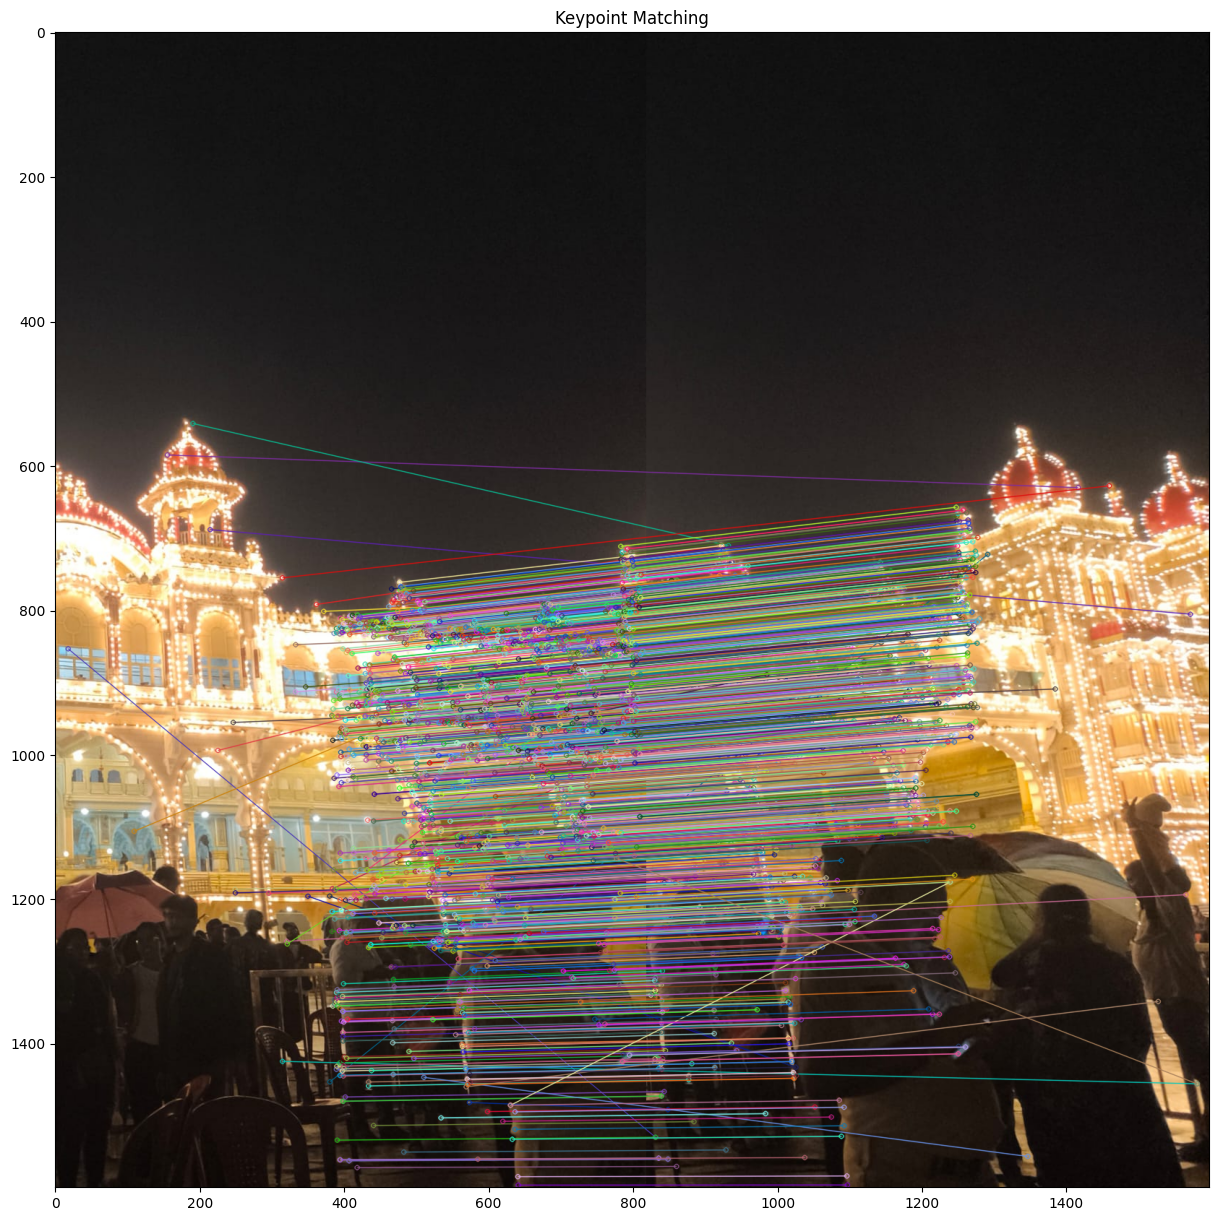

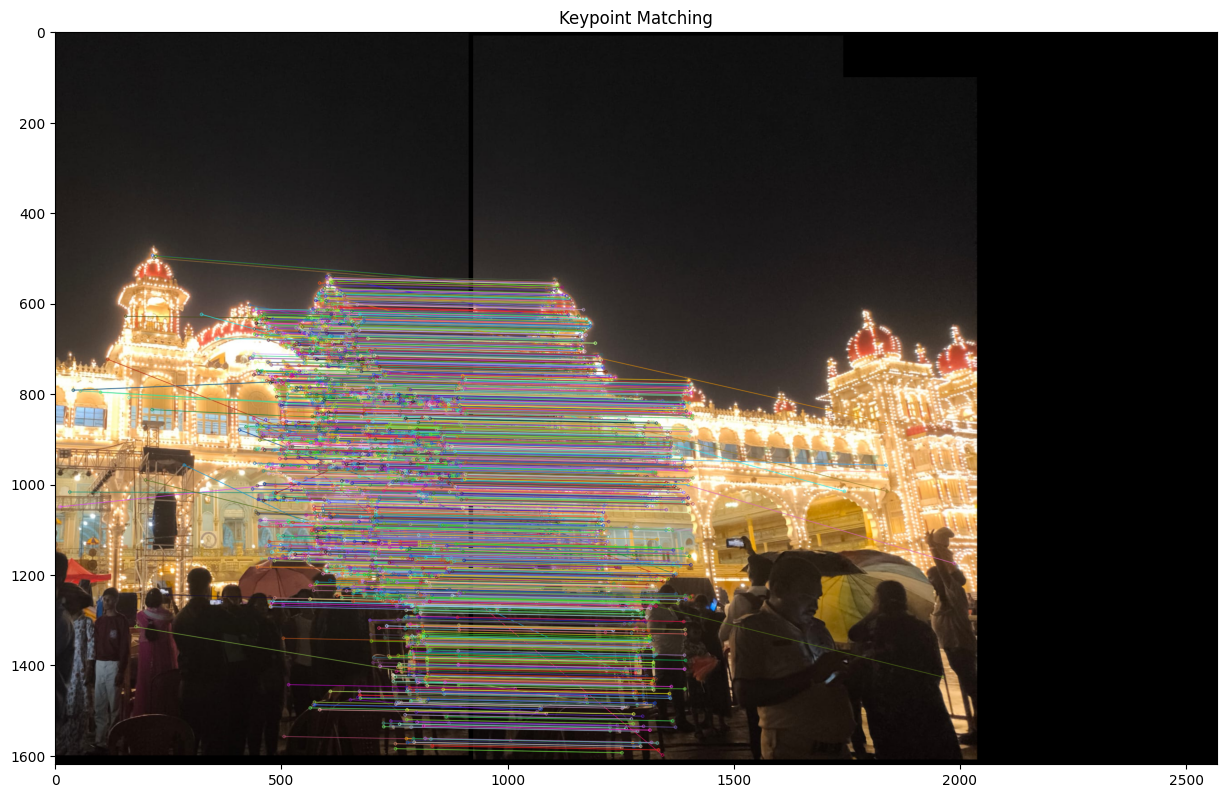

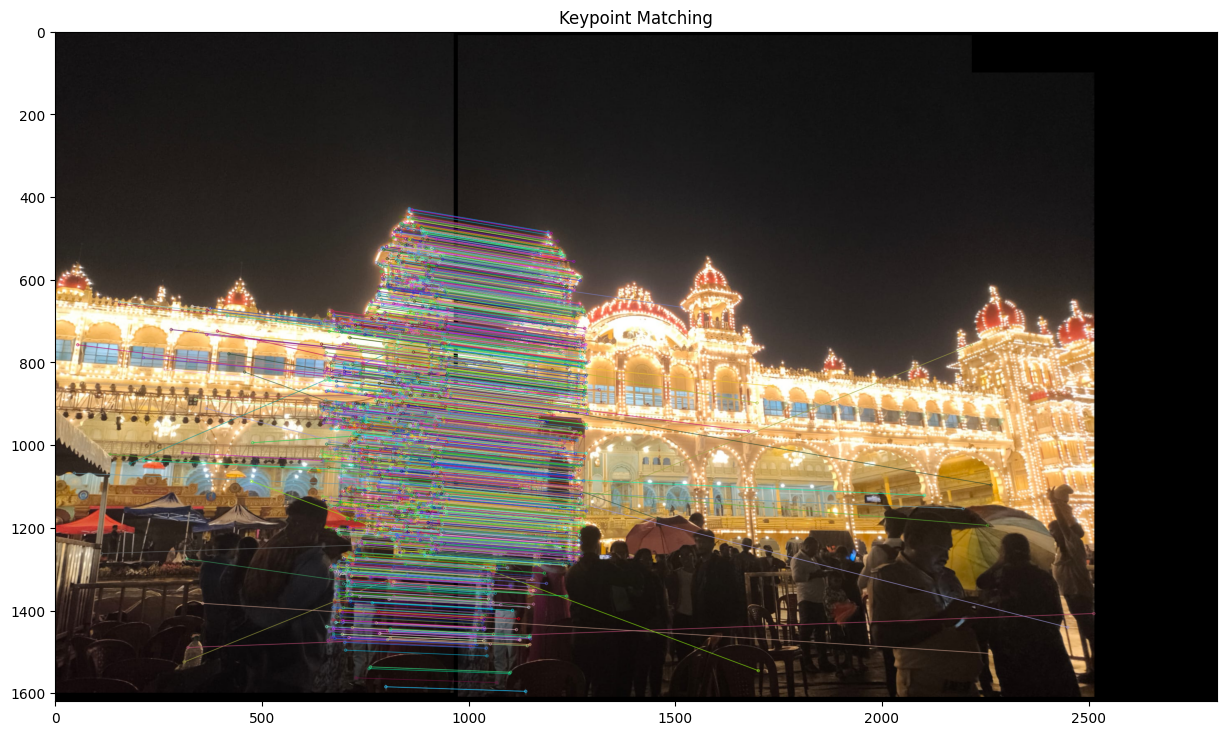

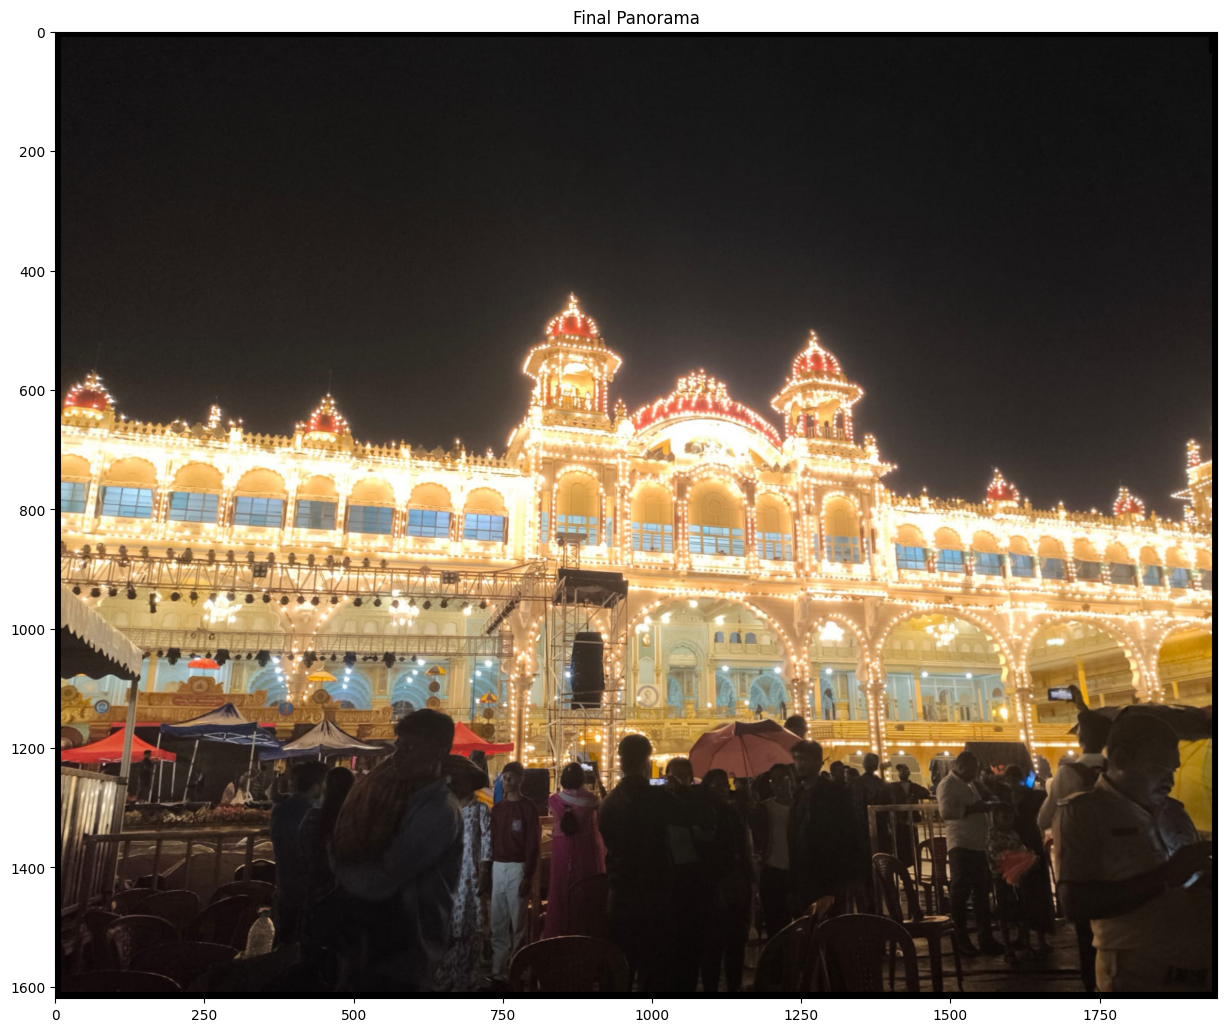

In [ ]:

panorama = None
imgs = []


directory_path = Path(DATASET_DIR)
print(sorted(f.name for f in directory_path.iterdir() if f.is_file()))
for img_file in sorted([f.name for f in directory_path.iterdir() if f.is_file()],reverse=True):
    img_path = directory_path / img_file
    img = cv2.imread(str(img_path))
    imgs.append(img)

if len(imgs) >= 2:
    panorama = stitch_images(imgs[0], imgs[1])
    for i in range(2, len(imgs)):
        panorama = stitch_images(panorama, imgs[i])
else:
    print("Not enough images to stitch.")
    exit()


plt.figure(figsize=(15, 15))
plt.imshow(cv2.cvtColor(panorama, cv2.COLOR_BGR2RGB))
plt.title("Final Panorama")
plt.show()